# Textual Retrieval System

This notebook demonstrates a robust framework for information retrieval using two popular text similarity models: **Cosine Similarity** and **BM25**. The goal is to develop a system that can process textual data, match user queries with relevant documents, and rank the results effectively.

## Objective
The primary objective of this notebook is to showcase:
1. The preprocessing pipeline required for cleaning and preparing text data.
2. The implementation and comparison of Cosine Similarity and BM25 models for query-document matching.
3. How to rank and retrieve the most relevant results for a give ae Processing (NLP).

## Workflow
1. **Data Preprocessing**: Text cleaning, tokenization, stopword removal, and lemmatization.
2. **Feature Extraction**: TF-IDF vectorization for Cosine Similarity and token frequencies for BM25.
3. **Similarity Computation**: Using mathematical formulations specific to each model.
4. **Result Ranking and Display**: Ranking documents based ont length play a critical rolewe
By the end of this notebook, you will understand how to preprocess text data, implement these models, and deploy an interactive query interface forretrieving and ranking documents.


In [38]:
#Necessary imports
import os
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from PIL import Image
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ishas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ishas\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

The SemArt dataset has been divided into 3 files: Train, test and validation. We will start by combining all the files into one.

In [19]:
train = pd.read_csv('SemArt/SemArt/semart_train.csv', encoding='latin-1',delimiter='\t')
test = pd.read_csv('SemArt/SemArt/semart_test.csv', encoding='latin-1',delimiter='\t')
val = pd.read_csv('SemArt/SemArt/semart_val.csv', encoding='latin-1',delimiter='\t')

In [20]:
train.shape, test.shape, val.shape

((19244, 9), (1069, 9), (1069, 9))

In [21]:
filenames = ['SemArt/SemArt/semart_train.csv','SemArt/SemArt/semart_test.csv','SemArt/SemArt/semart_val.csv']
merged_file = pd.DataFrame()
for filename in filenames:
    df = pd.read_csv(filename,encoding='latin-1',delimiter='\t')
    merged_file = pd.concat([merged_file, df], ignore_index=True)

In [22]:
merged_file.shape

(21382, 9)

In [23]:
merged_file.head()

IMAGE_FILE                                        DESCRIPTION  \
0   19873-1darmst.jpg  The Meyer or Darmstadt Madonna is the last, mo...   
1  18759-guard301.jpg  Whereas Canaletto incorporates classically ins...   
2  04589-temptati.jpg  In this painting the refinement of the colouri...   
3      15104-magi.jpg  The left side of the painting was cut, origina...   
4  36582-paolo_f1.jpg  The painting illustrates a famous episode from...   

                      AUTHOR  \
0  HOLBEIN, Hans the Younger   
1          GUARDI, Francesco   
2         BILIVERT, Giovanni   
3     GEERTGEN tot Sint Jans   
4              SCHEFFER, Ary   

                                               TITLE  \
0                                  Darmstadt Madonna   
1                  Landscape with a Fisherman's Tent   
2               The Temptation of Charles and Ubalde   
3                              Adoration of the Magi   
4  The Ghosts of Paolo and Francesca Appear to Da...   

                       TECHNIQUE                 DATE       TYPE  \
0  Oil on limewood, 147 x 102 cm  1526 and after 1528  religious   
1      Oil on canvas, 49 x 77 cm              1770-75  landscape   
2      Oil on copper, 37 x 28 cm              1629-30  religious   
3             Panel, 111 x 69 cm              1480-85  religious   
4    Oil on canvas, 167 x 234 cm                 1835      other   

          SCHOOL  TIMEFRAME  
0         German  1501-1550  
1        Italian  1751-1800  
2        Italian  1601-1650  
3  Netherlandish  1451-1500  
4          Dutch  1801-1850

In [12]:
merged_file.to_csv('CombinedSemArtData.csv')

In [24]:
df = merged_file.copy()

In [25]:
df.columns

Index(['IMAGE_FILE', 'DESCRIPTION', 'AUTHOR', 'TITLE', 'TECHNIQUE', 'DATE',
       'TYPE', 'SCHOOL', 'TIMEFRAME'],
      dtype='object')

To begin with, let's explore few images and their descriptions present in the dataset. This will help us understand the dataset in depth.

In [27]:
image_dir = os.path.expanduser("SemArt/SemArt/Images")

# Update the IMAGE_FILE column with the full file paths
df['IMAGE_FILE'] = df['IMAGE_FILE'].apply(lambda x: os.path.join(image_dir, x))

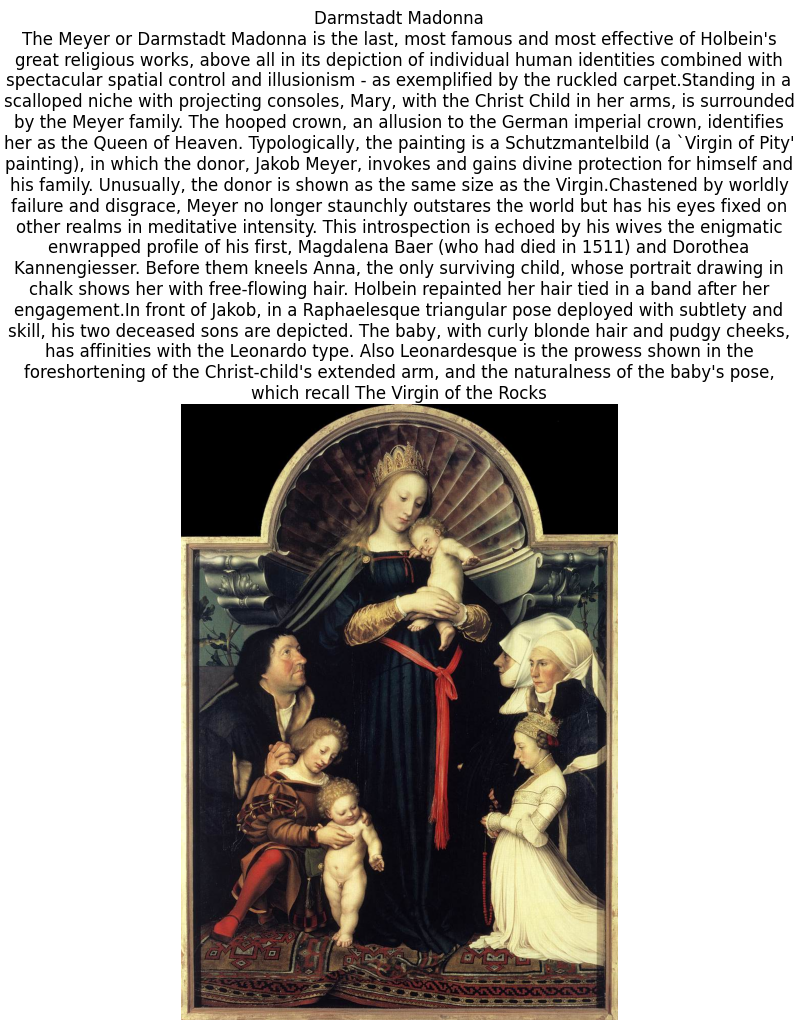

In [49]:
for i, row in df.head(1).iterrows():
    try:
        # Load the image
        img_path = row['IMAGE_FILE']
        img = Image.open(img_path)

        # Plot the image
        plt.figure(figsize=(8,8))  # Adjust size to fit the image and text
        plt.imshow(img)
        plt.axis('off')  # Hide axes

        # Add title and description
        title = row['TITLE']
        description = row['DESCRIPTION']
        plt.title(f"{title}\n{description}", fontsize=12, wrap=True)

        # Show the image with its description
        plt.show()

    except FileNotFoundError:
        print(f"File not found: {img_path}")
    except Exception as e:
        print(f"Error loading image {img_path}: {e}")

## Combining Text Features into a Single Column

This line of code creates a new column, COMBINED_TEXT, by concatenating three existing columns (TITLE, TECHNIQUE, and DESCRIPTION) in the DataFrame df. 
The concatenated text is separated by a space (" ") to ensure readability and proper tokenization during preprocessing.

### Why Do We Combine Text Features?

1. **Contextual Enrichment**
   Combining multiple textual fields provides richer and more comprehensive input for the model. For instance:
   - The TITLE might give a high-level overview.
   - The TECHNIQUE adds details about methods or processes.
   - The DESCRIPTION provides in-depth information.

Merging these ensures the model has access to all relevant information in a single representation.

2. **Feature Consolidation**
   Models like TF-IDF and BM25 work on a single block of text. Consolidating fields reduces complexity by presenting a unified representation for similarity computation.

3. **Improved Retrieval**
   Including diverse yet related fields in a single text improves the likelihood of capturing relevant query terms, enhancing the retrieval and ranking process.

In [29]:
df['COMBINED_TEXT'] = df['TITLE'] + " " + df['TECHNIQUE'] + " " + df['DESCRIPTION']

In [37]:
df[['COMBINED_TEXT']].head()

COMBINED_TEXT
0  Darmstadt Madonna Oil on limewood, 147 x 102 c...
1  Landscape with a Fisherman's Tent Oil on canva...
2  The Temptation of Charles and Ubalde Oil on co...
3  Adoration of the Magi Panel, 111 x 69 cm The l...
4  The Ghosts of Paolo and Francesca Appear to Da...

In [39]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

### Data Preprocessing

The data preprocessing pipeline is critical for preparing textual data for similarity computations. Below are the steps involved:

a. **Text Cleaning**
   - Non-alphabetical characters are removed to ensure consistency in text processing.
   - All characters are converted to lowercase for uniformity.

b. **Tokenization**
   - Sentences are split into individual words (tokens).

c. **Stopword Removal**
   - Commonly used words (e.g., "and", "the", "is") that do not add semantic value are removed using the NLTK stopwords list.

d. **Lemmatization**
   - Words are reduced to their base forms using `WordNetLemmatizer` (e.g., "running" becomes "run") to reduce redundancy and improve matching accuracy.

e. **Output**
   - A clean, tokenized, and lemmatized description of each dataset entry is prepared for further processing.

In [40]:
# Preprocessing function
def preprocess_text(text):
    if not isinstance(text, str):  # Handle non-string data
        return ""
    text = text.lower()  # Lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    tokens = text.split()  # Tokenize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]  # Remove stopwords & lemmatize
    return " ".join(tokens)

In [41]:
df['COMBINED_TEXT'] = df['COMBINED_TEXT'].apply(preprocess_text)

### Cosine Similarity Model

Cosine similarity is used to compute the relevance between a query and the dataset. Below are the detailed steps:

a. **TF-IDF Vectorization**
   - Text descriptions are converted into a Term Frequency-Inverse Document Frequency (TF-IDF) matrix using `TfidfVectorizer`.
     - **TF (Term Frequency):** Measures how often a word occurs in a document.
     - **IDF (Inverse Document Frequency):** Reduces the importance of frequently occurring terms across the dataset.

b. **Query Transformation**
   - The input query is preprocessed and vectorized using the same TF-IDF model to ensure consistency.

c. **Cosine Similarity Calculation**
   - The similarity between the query vector and document vectors is computed as:
     \ [
     \ text{cosine\_similarity}(A, B) = \frac{A \cdot B}{||A|| \times ||B||}
     \ ]
   - The similarity score lies between 0 and 1, where 1 indicates identical vectors.

d. **Ranking Results**
   - Documents are ranked based on their similarity scores in descending order, and the top results are displayed.

In [46]:
def search_artworks(query, top_n=5):
    # Preprocess the query
    query = preprocess_text(query)
    
    # Combine the query with the descriptions of all artworks
    artworks_texts = df['COMBINED_TEXT'].tolist()
    artworks_texts.append(query)  # Add the query as the last entry for comparison

    # Initialize TF-IDF Vectorizer
    vectorizer = TfidfVectorizer(stop_words='english')
    
    # Combine artworks texts and query into a single corpus
    corpus = artworks_texts
    
    # Vectorize the text (combined title, technique, description + query)
    tfidf_matrix = vectorizer.fit_transform(corpus)
    
    # Compute cosine similarity between the query (last row) and all combined texts
    cosine_sim = cosine_similarity(tfidf_matrix[-1], tfidf_matrix[:-1])  # Exclude the query itself
    cosine_sim = cosine_sim.flatten()  # Flatten to a 1D array

    # Get the top N matching indices based on cosine similarity
    top_indices = cosine_sim.argsort()[-top_n:][::-1]  # Top N indices in descending order of similarity
    
    # Retrieve top N artworks
    top_artworks = df.iloc[top_indices]
    
    # Display the images with their corresponding titles, techniques, and descriptions
    for i, row in top_artworks.iterrows():
        # Load the image
        img_path = row['IMAGE_FILE']
        img = Image.open(img_path)
        
        # Plot the image
        plt.figure(figsize=(8, 10))  # Adjust size to fit the image and text
        plt.imshow(img)
        plt.axis('off')  # Hide axes
        
        # Add title, technique, and description
        title = row['TITLE']
        technique = row['TECHNIQUE']
        description = row['DESCRIPTION']
        plt.title(f"{title}\nTechnique: {technique}\n{description}", fontsize=12, wrap=True)
        
        # Show the image with its details
        plt.show()

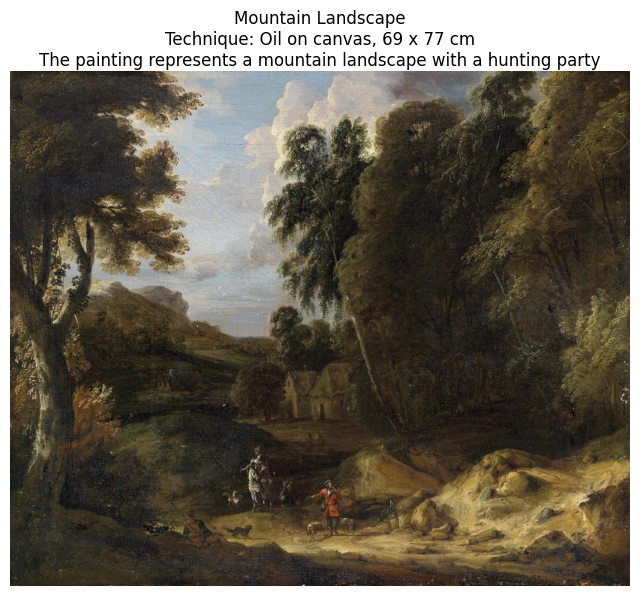

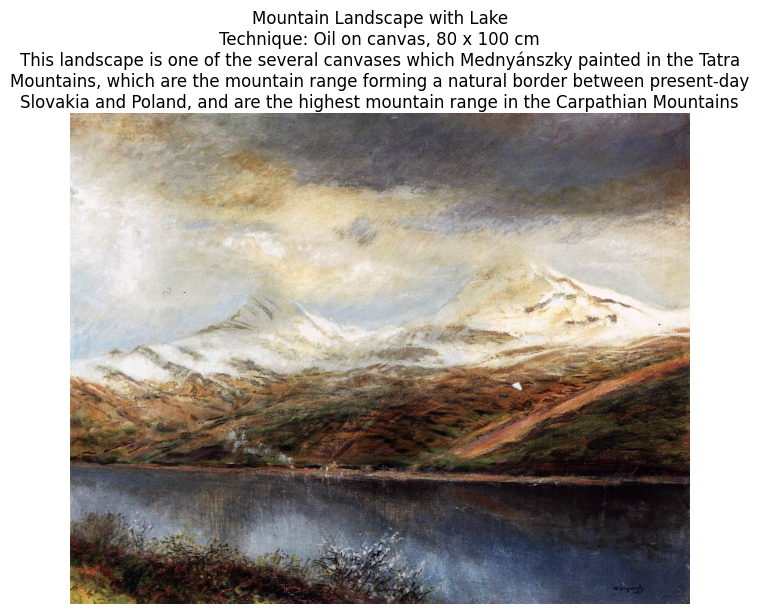

In [48]:
# Example usage 1:
query = "barren landscape with mountains"
search_artworks(query, top_n=2)

# BM25 Retriever Implementation

The given code provides a basic implementation of the BM25 (Best Matching 25) retrieval model, which is widely used in Information Retrieval for ranking documents based on the relevance to a query. Below is a step-by-step explanation of the code components:

### 1. **BM25Retriever Class**
The `BM25Retriever` class encapsulates the BM25 algorithm, which ranks documents based on the term frequency (TF), inverse document frequency (IDF), and document length normalization. The key parameters are:
- `k1`: Controls the term frequency scaling, typically between 1.2 and 2.0.
- `b`: A parameter that adjusts for document length normalization (usually set to 0.75).
- `k2`: Controls the scaling for the query term frequency (default 100).

#### Functions:
- **average_length_of_docs(docs)**:
    This function calculates the average document length by dividing the total number of terms in all documents by the number of documents. This value is used to normalize document length in BM25 scoring.

- **get_BM25_score(N, ni, K, fi, qfi)**:
    This function calculates the BM25 score for a single term in a document, considering factors like:
    - `N`: Total number of documents.
    - `ni`: Number of documents containing the term.
    - `K`: Length normalization factor.
    - `fi`: Frequency of the term in the document.
    - `qfi`: Frequency of ths frequency in a document.

- **get_top_relevant_documents(inverted_index, document_term_count, query, avdl)**:
    This function ranks the documents for a given query using the BM25 score. It iterates over the terms in the query, checks if the term is present in the inverted index, and calculates the BM25 score for each document containing the term. The function returns the top 20 documents sorted by their BM25 score.

- **process_query(query_id, query, inverted_index, avdl, document_term_count)**:
    This function takes a query and processes it to return the top 20 most relevant documents by invoking the `get_top_relevant_documents` method. It uses the inverted index and document term count to cal be used for building the inverted index.

### 3. **Build Inverted Index and Document Term Count**
The `build_inverted_index` function processes a DataFrame (`df`), where each row contains document information. It does the following:
- **Document Term Count**: It calculates the number of terms in each document after preprocessing.
- **Inverted Index**: It constructs an inverted index, where each unique term points to a list of document IDs and their respective term frequencies. This index is used to quickly look up which documents contain a specific term and how often the term appears in each document.

This function outputs two structures:
- `inverted_index`: A dictionary mapping each term to a list of document-term pairs.
- `document_term_count`: A dictionary mapping each dimized further depending on the use case and dataset size.


In [42]:
import math
import pandas as pd
import nltk
from collections import OrderedDict
import re

# Define a basic BM25 implementation
class BM25Retriever:
    def __init__(self, k1=1.2, b=0.75, k2=100):
        self.k1 = k1
        self.b = b
        self.k2 = k2

    def average_length_of_docs(self, docs):
        total_length = sum(len(doc.split()) for doc in docs)
        return total_length / len(docs)

    def get_BM25_score(self, N, ni, K, fi, qfi):
        return math.log((N - ni + 0.5) / (ni + 0.5)) * ((self.k1 + 1) * fi) / (K + fi) * ((self.k2 + 1) * qfi) / (self.k2 + qfi)

    def get_top_relevant_documents(self, inverted_index, document_term_count, query, avdl):
        score_list = dict()
        N = len(document_term_count)
        query_terms = nltk.FreqDist(query.split())

        for term, freq in query_terms.items():
            if term not in inverted_index:
                continue
            inv_list = inverted_index[term]
            for posting in inv_list:
                doc_id = posting[0]
                doc_length = document_term_count[doc_id]
                K = self.k1 * ((1 - self.b) + self.b * (doc_length / avdl))
                score = self.get_BM25_score(N, len(inv_list), K, posting[1], freq)
                score_list[doc_id] = score_list.get(doc_id, 0) + score
        
        return OrderedDict(sorted(score_list.items(), key=lambda item: item[1], reverse=True)[:20])

    def process_query(self, query_id, query, inverted_index, avdl, document_term_count):
        results = self.get_top_relevant_documents(inverted_index, document_term_count, query, avdl)
        return results

# Build inverted index and document term count from DataFrame
def build_inverted_index(df):
    inverted_index = {}
    document_term_count = {}

    for index, row in df.iterrows():
        doc_id = row['IMAGE_FILE']
        text = row['COMBINED_TEXT']
        processed_text = preprocess_text(text)
        tokens = processed_text.split()
        document_term_count[doc_id] = len(tokens)

        for term in set(tokens):
            if term not in inverted_index:
                inverted_index[term] = []
            inverted_index[term].append((doc_id, tokens.count(term)))

    return inverted_index, document_term_count

In [43]:
# Build inverted index and document term count
inverted_index, document_term_count = build_inverted_index(df)

# Initialize BM25 retriever and fetch results
bm25 = BM25Retriever()
avdl = bm25.average_length_of_docs(df['COMBINED_TEXT'])  # Average document length in the corpus

Top 20 results for the query: Ships and navy
1. A Navy Yacht Flying the White Ensign - Oil on canvas, 46 x 92 cm | BM25 score: 11.2525
   Description: This painting depicts a navy yacht flying the white ensign coming up to harbour in the Downs; a French frigate at anchor beyond; a rain shower approaching
   Image File: SemArt/SemArt/Images\44127-navyacht.jpg



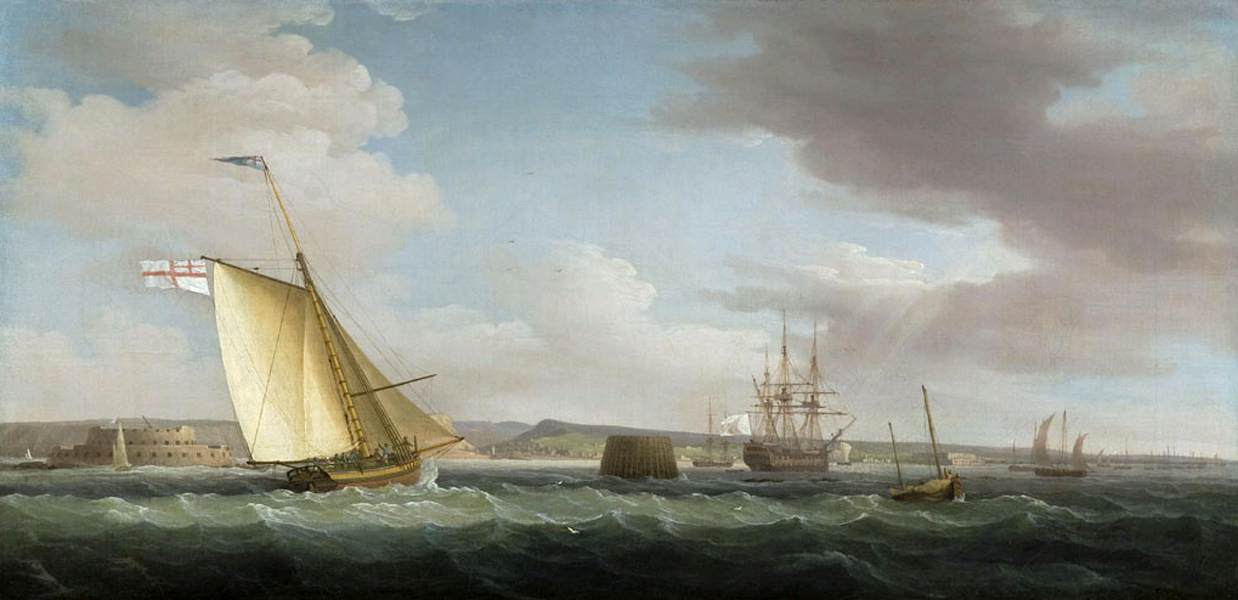

2. The Dutch Navy Sailing - Oil on canvas, 112 x 203 cm | BM25 score: 10.6475
   Description: Ships in all their detailed individuality were Willem van de Velde's speciality. He often sailed with the Dutch and later the British navies, drawing studies that, once ashore, he painted as grisailles, such as this one. He made the sketch for this work at sea during the outbreak of the Third Anglo-Dutch War in 1672
   Image File: SemArt/SemArt/Images\42380-dutchnav.jpg



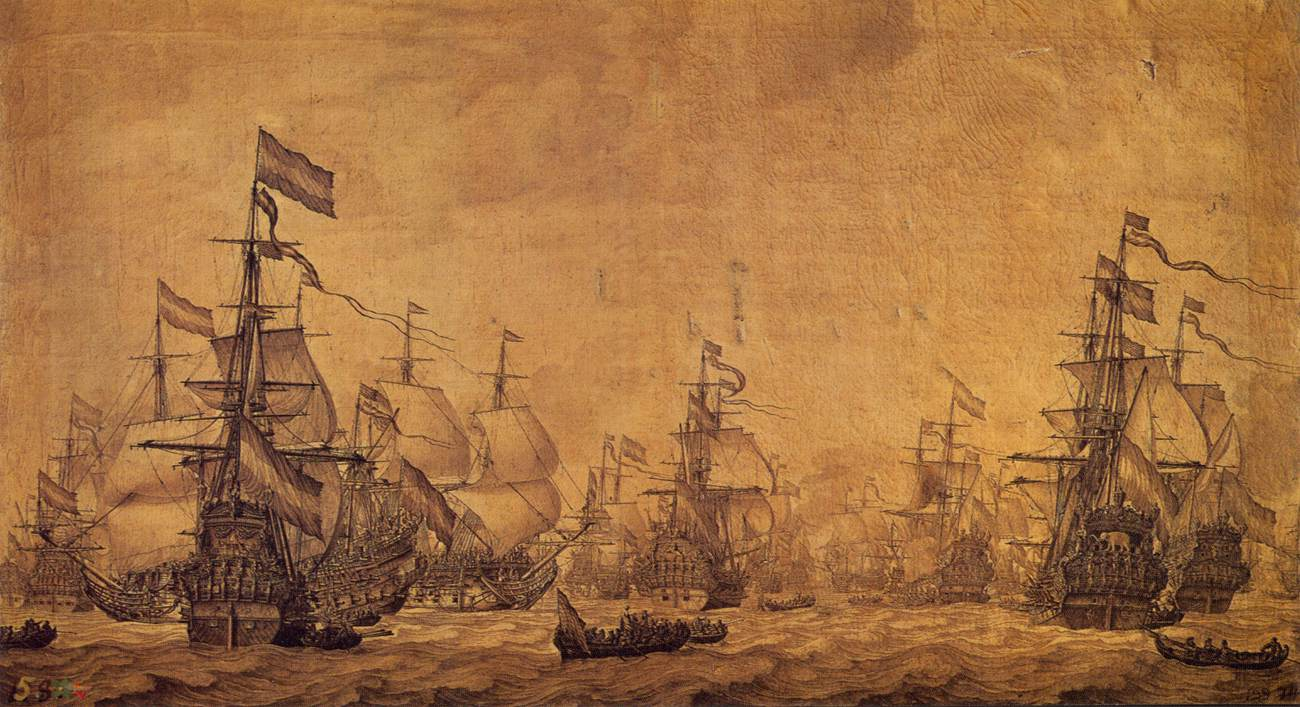

In [45]:
query = "Ships and navy"
results = bm25.process_query(1, query, inverted_index, avdl, document_term_count)

top_results = list(results.items())[:2]
print("Top 20 results for the query:", query)
for rank, (doc_id, score) in enumerate(top_results, start=1):
    # Retrieve relevant metadata from the dataframe
    artwork_info = df[df['IMAGE_FILE'] == doc_id].iloc[0]
    title = artwork_info['TITLE']
    technique = artwork_info['TECHNIQUE']
    description = artwork_info['DESCRIPTION']
    image_file = artwork_info['IMAGE_FILE']  # Assuming IMAGE_FILE is the path to the image
    
    print(f"{rank}. {title} - {technique} | BM25 score: {score:.4f}")
    print(f"   Description: {description}")
    print(f"   Image File: {image_file}\n")  # This will show the image file or URL
    try:
        image = Image.open(image_file)  # Open the image
        display(image)  # Display the image (for Jupyter Notebooks)
    except Exception as e:
        print(f"Error displaying image: {e}")